In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os
import json
import warnings
warnings.filterwarnings("ignore")

# Check GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

2025-11-09 10:48:31.594984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762685311.803137      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762685311.874446      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# Configuration - Optimized for imbalanced data
class Config:
    # Training parameters
    EPOCHS = 80
    IMG_SIZE = 224
    BATCH_SIZE = 32
    LR = 1e-4
    VALIDATION_SPLIT = 0.15
    TEST_SPLIT = 0.10
    SEED = 42

    # Model specific settings
    PATIENCE = 15
    FACTOR = 0.5
    MIN_LR = 1e-7

    # Class imbalance handling
    USE_CLASS_WEIGHTS = True
    USE_FOCAL_LOSS = True
    FOCAL_ALPHA = 0.25
    FOCAL_GAMMA = 2.0

config = Config()
print("Configuration loaded successfully")
print(f"Training for {config.EPOCHS} epochs with batch size {config.BATCH_SIZE}")

Configuration loaded successfully
Training for 80 epochs with batch size 32


In [3]:
# Focal Loss for handling class imbalance - FIXED for sparse labels
class FocalLoss(tf.keras.losses.Loss):
    """
    Focal Loss for multi-class classification with class imbalance.
    Compatible with sparse integer labels.
    """
    def __init__(self, alpha=0.25, gamma=2.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Ensure y_true is the right shape (batch_size,) for sparse labels
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)

        # Get number of classes from predictions
        num_classes = tf.shape(y_pred)[-1]

        # Convert to one-hot
        y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

        # Clip predictions to prevent log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Calculate cross entropy
        ce = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred), axis=-1)

        # Get the predicted probability for the true class
        p_t = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)

        # Compute focal weight
        focal_weight = self.alpha * tf.pow(1.0 - p_t, self.gamma)

        # Focal loss
        focal_loss = focal_weight * ce

        return tf.reduce_mean(focal_loss)

    def get_config(self):
        config = super().get_config()
        config.update({
            'alpha': self.alpha,
            'gamma': self.gamma
        })
        return config

print("Focal Loss class defined successfully")

Focal Loss class defined successfully


In [4]:
# Data loading - Load ALL available data
def create_df(path):
    """Load all images from the dataset directory structure"""
    dd = {"images": [], "labels": []}

    for class_name in os.listdir(path):
        class_dir = os.path.join(path, class_name)

        # Skip if not a directory
        if not os.path.isdir(class_dir):
            print(f"Skipping non-directory: {class_name}")
            continue

        # Check for subdirectories
        subdirs = [d for d in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, d))]

        if len(subdirs) == 0:
            # No subdirectories, images are directly in class folder
            img_dir_full = class_dir
        else:
            # Images are in a subdirectory
            addition = subdirs[0]
            img_dir_full = os.path.join(class_dir, addition)

        # Load ALL images (no limit)
        count = 0
        for img_file in os.listdir(img_dir_full):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                dd["images"].append(os.path.join(img_dir_full, img_file))
                dd["labels"].append(class_name)
                count += 1

        print(f"Loaded {count} images from class: {class_name}")

    return pd.DataFrame(dd)

print("Data loading function defined")

Data loading function defined


In [5]:
# Strong data augmentation for minority classes
def augment_image(image, label):
    """Enhanced data augmentation for better generalization"""
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random brightness adjustment
    image = tf.image.random_brightness(image, 0.15)

    # Random contrast adjustment
    image = tf.image.random_contrast(image, 0.85, 1.15)

    # Random saturation adjustment
    image = tf.image.random_saturation(image, 0.85, 1.15)

    # Random hue adjustment
    image = tf.image.random_hue(image, 0.08)

    # Random rotation (90 degree increments)
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))

    # Random zoom (crop and resize)
    if tf.random.uniform([]) > 0.5:
        crop_size = tf.random.uniform([], 0.85, 1.0)
        h, w = tf.shape(image)[0], tf.shape(image)[1]
        crop_h = tf.cast(tf.cast(h, tf.float32) * crop_size, tf.int32)
        crop_w = tf.cast(tf.cast(w, tf.float32) * crop_size, tf.int32)
        image = tf.image.random_crop(image, [crop_h, crop_w, 3])
        image = tf.image.resize(image, [Config.IMG_SIZE, Config.IMG_SIZE])

    # Clip values to valid range
    image = tf.clip_by_value(image, -1.0, 1.0)

    return image, label

def preprocess_image(image_path, img_size=Config.IMG_SIZE):
    """Load and preprocess a single image"""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [img_size, img_size])
    image = tf.cast(image, tf.float32) / 255.0
    # Normalize to [-1, 1] range
    image = (image - 0.5) * 2.0
    return image

def create_dataset(df, batch_size=Config.BATCH_SIZE, shuffle=True, augment=False):
    """Create TensorFlow dataset from DataFrame"""

    def load_and_preprocess_image(path, label):
        return preprocess_image(path), label

    # Create dataset from paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((df['images'].values, df['labels'].values))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=2000, seed=Config.SEED)

    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

print("Data preprocessing and augmentation functions defined")

Data preprocessing and augmentation functions defined


In [6]:
# Custom Keras Layers for Axial Attention
class AxialAttentionLayer(layers.Layer):
    """Custom Keras Layer for Axial Attention"""

    def __init__(self, axis=0, num_heads=4, mlp_dim=128, dropout_rate=0.1, **kwargs):
        super(AxialAttentionLayer, self).__init__(**kwargs)
        self.axis = axis
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)
        self.qkv_dense = layers.Dense(self.channels * 3)
        self.proj_dense = layers.Dense(self.channels)
        self.dropout = layers.Dropout(self.dropout_rate)
        super(AxialAttentionLayer, self).build(input_shape)

    def call(self, inputs, training=None):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]

        # Reshape based on axis
        if self.axis == 0:  # Height axis
            x_reshaped = inputs
            seq_len = height
        else:  # Width axis
            x_reshaped = tf.reshape(inputs, [batch_size * height, width, self.channels])
            seq_len = width

        # Layer norm
        x_norm = self.layer_norm(x_reshaped)

        # Linear projection to Q, K, V
        qkv = self.qkv_dense(x_norm)

        if self.axis == 0:
            qkv = tf.reshape(qkv, [batch_size, height, width, self.num_heads, self.channels // self.num_heads * 3])
            qkv = tf.transpose(qkv, [0, 2, 3, 1, 4])
            qkv = tf.reshape(qkv, [batch_size * width, self.num_heads, height, self.channels // self.num_heads * 3])
        else:
            qkv = tf.reshape(qkv, [-1, width, self.num_heads, self.channels // self.num_heads * 3])
            qkv = tf.transpose(qkv, [0, 2, 1, 3])

        q, k, v = tf.split(qkv, 3, axis=-1)

        # Scaled dot-product attention
        scale = tf.math.rsqrt(tf.cast(self.channels // self.num_heads, tf.float32))
        attn = tf.matmul(q * scale, k, transpose_b=True)
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.dropout(attn, training=training)

        out = tf.matmul(attn, v)
        out = tf.transpose(out, [0, 2, 1, 3])

        if self.axis == 0:
            out = tf.reshape(out, [batch_size, width, height, self.channels])
            out = tf.transpose(out, [0, 2, 1, 3])
        else:
            out = tf.reshape(out, [batch_size, height, width, self.channels])

        # Project back
        out = self.proj_dense(out)
        out = self.dropout(out, training=training)

        # Residual connection
        return layers.Add()([out, inputs])

    def get_config(self):
        config = super().get_config()
        config.update({
            'axis': self.axis,
            'num_heads': self.num_heads,
            'mlp_dim': self.mlp_dim,
            'dropout_rate': self.dropout_rate
        })
        return config


class ChannelAttentionLayer(layers.Layer):
    """Custom Keras Layer for Channel Attention"""

    def __init__(self, reduction_ratio=16, **kwargs):
        super(ChannelAttentionLayer, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.global_pool = layers.GlobalAveragePooling2D(keepdims=True)
        self.fc1 = layers.Dense(max(self.channels // self.reduction_ratio, 1), activation='gelu')
        self.fc2 = layers.Dense(self.channels, activation='sigmoid')
        super(ChannelAttentionLayer, self).build(input_shape)

    def call(self, inputs):
        squeeze = self.global_pool(inputs)
        excitation = self.fc1(squeeze)
        excitation = self.fc2(excitation)
        return layers.Multiply()([inputs, excitation])

    def get_config(self):
        config = super().get_config()
        config.update({'reduction_ratio': self.reduction_ratio})
        return config


def efficient_2d_convblock(x, filters, kernel_size=3, strides=1, use_bn=True, use_activation=True):
    """EfficientNetV2-style 2D conv"""
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    if use_activation:
        x = layers.Activation('gelu')(x)
    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    if use_activation:
        x = layers.Activation('gelu')(x)
    return x


def build_model(input_shape, num_classes):
    """Hybrid Efficient Axial Attention Architecture"""

    inputs = keras.Input(shape=input_shape)

    # STEM
    x = layers.Conv2D(32, 4, strides=4, padding='valid', use_bias=False, name='stem_conv')(inputs)
    x = layers.BatchNormalization(name='stem_bn')(x)
    x = layers.Activation('gelu', name='stem_activation')(x)

    # STAGE 1
    x = efficient_2d_convblock(x, 48, kernel_size=3, strides=1)
    x = ChannelAttentionLayer(reduction_ratio=16, name='channel_attn_1')(x)
    x = layers.MaxPooling2D(2, strides=2, padding='same', name='pool_1')(x)

    # STAGE 2
    x = efficient_2d_convblock(x, 64, kernel_size=3, strides=1)
    x = ChannelAttentionLayer(reduction_ratio=16, name='channel_attn_2')(x)
    x = AxialAttentionLayer(axis=0, num_heads=4, mlp_dim=128, dropout_rate=0.15, name='axial_attn_height')(x)
    x = layers.MaxPooling2D(2, strides=2, padding='same', name='pool_2')(x)

    # STAGE 3
    x = efficient_2d_convblock(x, 128, kernel_size=3, strides=1)
    x = ChannelAttentionLayer(reduction_ratio=16, name='channel_attn_3')(x)
    x = AxialAttentionLayer(axis=1, num_heads=4, mlp_dim=256, dropout_rate=0.15, name='axial_attn_width')(x)
    x = layers.MaxPooling2D(2, strides=2, padding='same', name='pool_3')(x)

    # STAGE 4
    x = efficient_2d_convblock(x, 256, kernel_size=3, strides=1)
    x = ChannelAttentionLayer(reduction_ratio=16, name='channel_attn_4')(x)

    # CLASSIFICATION HEAD
    x = layers.GlobalAveragePooling2D(name='global_pool')(x)
    x = layers.LayerNormalization(epsilon=1e-6, name='final_norm')(x)
    x = layers.Dense(512, activation='gelu', name='fc1')(x)
    x = layers.Dropout(0.5, name='dropout1')(x)
    x = layers.Dense(256, activation='gelu', name='fc2')(x)
    x = layers.Dropout(0.4, name='dropout2')(x)

    outputs = layers.Dense(num_classes, activation='softmax', name='classification')(x)

    model = keras.Model(inputs, outputs, name='axial_efficientnet_2d')
    return model

print("Model architecture with custom Keras layers defined successfully")

Model architecture with custom Keras layers defined successfully


In [7]:
# Training function - FIXED: Removed AUC metric to avoid shape mismatch
def train_model(model, train_dataset, val_dataset, class_weights, model_name, epochs=Config.EPOCHS):
    """Train model with focal loss and class weights"""

    # Use Focal Loss for imbalanced data
    if Config.USE_FOCAL_LOSS:
        loss = FocalLoss(alpha=Config.FOCAL_ALPHA, gamma=Config.FOCAL_GAMMA)
        print(f"Using Focal Loss (alpha={Config.FOCAL_ALPHA}, gamma={Config.FOCAL_GAMMA})")
    else:
        loss = 'sparse_categorical_crossentropy'
        print("Using standard categorical crossentropy")

    # Compile model - Using only accuracy metric (AUC removed to fix shape error)
    model.compile(
        optimizer=AdamW(learning_rate=Config.LR, weight_decay=1e-5),
        loss=loss,
        metrics=['accuracy']  # Removed AUC metric
    )

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=Config.PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=Config.FACTOR,
            patience=Config.PATIENCE//2,
            min_lr=Config.MIN_LR,
            verbose=1
        ),
        ModelCheckpoint(
            f'best_{model_name}.keras',
            monitor='val_accuracy',  # Changed from val_auc to val_accuracy
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

    # Train model with class weights if enabled
    if Config.USE_CLASS_WEIGHTS and class_weights is not None:
        print("Training with class weights to handle imbalance")
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
    else:
        print("Training without class weights")
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )

    return history

print("Training function defined")

Training function defined


In [8]:
# Evaluation functions
def evaluate_model(model, test_dataset, test_labels, class_names, model_name):
    """Comprehensive model evaluation"""

    # Get predictions
    print("\nGenerating predictions...")
    predictions = model.predict(test_dataset, verbose=1)
    y_pred = np.argmax(predictions, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(test_labels, y_pred)

    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*60}")
    print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Classification report
    clf_report_dict = classification_report(test_labels, y_pred, 
                                           target_names=class_names, 
                                           output_dict=True,
                                           zero_division=0)

    clf_report_str = classification_report(test_labels, y_pred, 
                                          target_names=class_names,
                                          zero_division=0)
    print("\nClassification Report:")
    print(clf_report_str)

    # Confusion Matrix
    cm = confusion_matrix(test_labels, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Per-class accuracy
    print("\nPer-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_mask = test_labels == i
        class_acc = accuracy_score(test_labels[class_mask], y_pred[class_mask])
        class_count = np.sum(class_mask)
        print(f"  {class_name}: {class_acc:.4f} ({class_acc*100:.2f}%) - {class_count} samples")

    # Prepare evaluation metrics dictionary
    evaluation_metrics = {
        'model_name': model_name,
        'test_accuracy': float(accuracy),
        'classification_report': clf_report_dict,
        'confusion_matrix': cm.tolist(),
        'class_names': class_names,
        'num_test_samples': len(test_labels),
        'prediction_confidence_mean': float(np.mean(np.max(predictions, axis=1))),
        'prediction_confidence_std': float(np.std(np.max(predictions, axis=1))),
        'per_class_samples': {
            class_name: int(np.sum(test_labels == i)) 
            for i, class_name in enumerate(class_names)
        },
        'per_class_accuracy': {
            class_name: float(accuracy_score(
                test_labels[test_labels == i], 
                y_pred[test_labels == i]
            )) if np.sum(test_labels == i) > 0 else 0.0
            for i, class_name in enumerate(class_names)
        }
    }

    return evaluation_metrics

def plot_training_history(history, model_name):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def save_metrics_to_json(history, evaluation_metrics, model_name, filename=None):
    """Save training history and evaluation metrics to JSON"""
    if filename is None:
        filename = f"{model_name}_metrics.json"

    def convert_to_serializable(obj):
        if isinstance(obj, (np.ndarray, np.generic)):
            return obj.tolist()
        elif isinstance(obj, (np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.int32, np.int64)):
            return int(obj)
        return obj

    metrics_data = {
        "model_name": model_name,
        "training_history": {
            key: [convert_to_serializable(val) for val in values] 
            for key, values in history.history.items()
        },
        "evaluation_metrics": {
            key: convert_to_serializable(value) 
            for key, value in evaluation_metrics.items()
        },
        "training_info": {
            "total_epochs": len(history.history['loss']),
            "best_val_accuracy": convert_to_serializable(max(history.history.get('val_accuracy', [0]))),
            "best_val_loss": convert_to_serializable(min(history.history.get('val_loss', [float('inf')]))),
            "final_train_accuracy": convert_to_serializable(history.history['accuracy'][-1]),
            "final_train_loss": convert_to_serializable(history.history['loss'][-1])
        }
    }

    with open(filename, 'w') as f:
        json.dump(metrics_data, f, indent=4)

    print(f"\nMetrics saved to {filename}")
    return filename

print("Evaluation functions defined")

Evaluation functions defined


In [9]:
# Main execution function
def main():
    """Main execution function with class imbalance handling"""

    # Load and prepare data
    print("="*60)
    print("Loading Alzheimer's Dataset")
    print("="*60)

    data_path = "/kaggle/input/well-documented-alzheimers-dataset"
    train_df = create_df(data_path)

    print(f"\nTotal samples loaded: {len(train_df)}")

    # Analyze class distribution
    print("\nClass Distribution:")
    class_counts = train_df['labels'].value_counts().sort_index()
    for class_name, count in class_counts.items():
        percentage = (count / len(train_df)) * 100
        print(f"  {class_name}: {count} samples ({percentage:.2f}%)")

    # Create label mappings
    unique_labels = sorted(train_df["labels"].unique())
    label_index = {label: i for i, label in enumerate(unique_labels)}
    index_label = {i: label for i, label in enumerate(unique_labels)}

    # Convert labels to integers
    train_df["labels"] = train_df["labels"].map(label_index)
    num_classes = len(unique_labels)
    class_names = unique_labels

    print(f"\nNumber of classes: {num_classes}")
    print(f"Class names: {class_names}")
    print(f"Label mapping: {label_index}")

    # Compute class weights
    if Config.USE_CLASS_WEIGHTS:
        class_weights_array = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(train_df['labels']),
            y=train_df['labels']
        )
        class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
        print("\nClass Weights (to handle imbalance):")
        for i, weight in class_weights.items():
            print(f"  {class_names[i]}: {weight:.4f}")
    else:
        class_weights = None

    # Split data with stratification
    print("\nSplitting dataset...")
    train_val_df, test_df = train_test_split(
        train_df, 
        test_size=Config.TEST_SPLIT, 
        stratify=train_df['labels'], 
        random_state=Config.SEED
    )

    train_df_final, val_df = train_test_split(
        train_val_df, 
        test_size=Config.VALIDATION_SPLIT/(1-Config.TEST_SPLIT), 
        stratify=train_val_df['labels'], 
        random_state=Config.SEED
    )

    print(f"Train samples: {len(train_df_final)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")

    # Print class distribution in splits
    print("\nClass distribution in splits:")
    for split_name, split_df in [("Train", train_df_final), ("Val", val_df), ("Test", test_df)]:
        print(f"\n{split_name}:")
        split_counts = split_df['labels'].value_counts().sort_index()
        for i, count in split_counts.items():
            print(f"  {class_names[i]}: {count} samples")

    # Create datasets
    print("\nCreating TensorFlow datasets...")
    train_dataset = create_dataset(train_df_final, batch_size=Config.BATCH_SIZE, 
                                   shuffle=True, augment=True)
    val_dataset = create_dataset(val_df, batch_size=Config.BATCH_SIZE, 
                                 shuffle=False, augment=False)
    test_dataset = create_dataset(test_df, batch_size=Config.BATCH_SIZE, 
                                  shuffle=False, augment=False)

    model_name = "axial_efficientnet_v1"

    # Train and evaluate model
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    try:
        # Create model
        model = build_model(
            input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3),
            num_classes=num_classes
        )

        print(f"\nModel architecture created for {model_name}")
        print(f"Total parameters: {model.count_params():,}")

        # Display model summary
        model.summary()

        # Train model
        print("\nStarting training...")
        history = train_model(model, train_dataset, val_dataset, 
                            class_weights, model_name, epochs=Config.EPOCHS)

        # Plot training history
        plot_training_history(history, model_name)

        # Evaluate model
        print("\nEvaluating model on test set...")
        evaluation_metrics = evaluate_model(
            model, test_dataset, test_df['labels'].values, 
            class_names, model_name
        )

        # Save metrics to JSON
        save_metrics_to_json(history, evaluation_metrics, model_name)

        # Print final summary
        print(f"\n{'='*60}")
        print("TRAINING COMPLETE")
        print(f"{'='*60}")
        print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
        print(f"Best Validation Loss: {min(history.history['val_loss']):.4f}")
        print(f"Test Accuracy: {evaluation_metrics['test_accuracy']:.4f}")
        print(f"\nModel saved as: best_{model_name}.keras")
        print(f"Metrics saved as: {model_name}_metrics.json")
        print(f"{'='*60}")

        # Clear memory
        del model
        tf.keras.backend.clear_session()

        return evaluation_metrics

    except Exception as e:
        print(f"\nError training {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

print("Main function defined")

Main function defined


Found 2 GPU(s)
Loading Alzheimer's Dataset
Loaded 376 images from class: ModerateDemented
Loaded 63560 images from class: NonDemented (2)
Skipping non-directory: oasis_cross-sectional-5708aa0a98d82080 (1).xlsx
Loaded 13796 images from class: VeryMildDemented
Loaded 5184 images from class: MildDemented

Total samples loaded: 82916

Class Distribution:
  MildDemented: 5184 samples (6.25%)
  ModerateDemented: 376 samples (0.45%)
  NonDemented (2): 63560 samples (76.66%)
  VeryMildDemented: 13796 samples (16.64%)

Number of classes: 4
Class names: ['MildDemented', 'ModerateDemented', 'NonDemented (2)', 'VeryMildDemented']
Label mapping: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented (2)': 2, 'VeryMildDemented': 3}

Class Weights (to handle imbalance):
  MildDemented: 3.9986
  ModerateDemented: 55.1303
  NonDemented (2): 0.3261
  VeryMildDemented: 1.5025

Splitting dataset...
Train samples: 62186
Validation samples: 12438
Test samples: 8292

Class distribution in splits:

Train:
  

I0000 00:00:1762685330.850413      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762685330.851197      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Training axial_efficientnet_v1

Model architecture created for axial_efficientnet_v1
Total parameters: 411,843


Model: "axial_efficientnet_2d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_conv (Conv2D)              │ (None, 56, 56, 32)     │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_bn (BatchNormalization)    │ (None, 56, 56, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_activation (Activation)    │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 56, 56, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 56, 56, 48)     │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 56, 56, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ channel_attn_1                  │ (None, 56, 56, 48)     │           339 │
│ (ChannelAttentionLayer)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 28, 28, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 28, 28, 48)     │           432 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ channel_attn_2                  │ (None, 28, 28, 64)     │           580 │
│ (ChannelAttentionLayer)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ axial_attn_height               │ (None, 28, 28, 64)     │        16,768 │
│ (AxialAttentionLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 411,843 (1.57 MB)

 Trainable params: 410,243 (1.56 MB)

 Non-trainable params: 1,600 (6.25 KB)


Starting training...
Using Focal Loss (alpha=0.25, gamma=2.0)
Training with class weights to handle imbalance
Epoch 1/80


I0000 00:00:1762685349.675042      61 service.cc:148] XLA service 0x7ec46010d8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762685349.675977      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762685349.676003      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762685351.697557      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/1944 ━━━━━━━━━━━━━━━━━━━━ 1:01 31ms/step - accuracy: 0.3887 - loss: 0.2676

I0000 00:00:1762685365.875900      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1944/1944 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7074 - loss: 0.1005
Epoch 1: val_accuracy improved from -inf to 0.77014, saving model to best_axial_efficientnet_v1.keras
1944/1944 ━━━━━━━━━━━━━━━━━━━━ 301s 138ms/step - accuracy: 0.7075 - loss: 0.1005 - val_accuracy: 0.7701 - val_loss: 0.0631 - learning_rate: 1.0000e-04
Epoch 2/80
1942/1944 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7501 - loss: 0.0700
Epoch 2: val_accuracy improved from 0.77014 to 0.77464, saving model to best_axial_efficientnet_v1.keras
1944/1944 ━━━━━━━━━━━━━━━━━━━━ 152s 77ms/step - accuracy: 0.7501 - loss: 0.0700 - val_accuracy: 0.7746 - val_loss: 0.0599 - learning_rate: 1.0000e-04
Epoch 3/80
1943/1944 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7605 - loss: 0.0658
Epoch 3: val_accuracy did not improve from 0.77464
1944/1944 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - accuracy: 0.7605 - loss: 0.0658 - val_accuracy: 0.7601 - val_loss: 0.0553 - learning_rate: 1.0000e-04
Epoch 4/80
1942/1944 ━━━━━━━━━━━━━

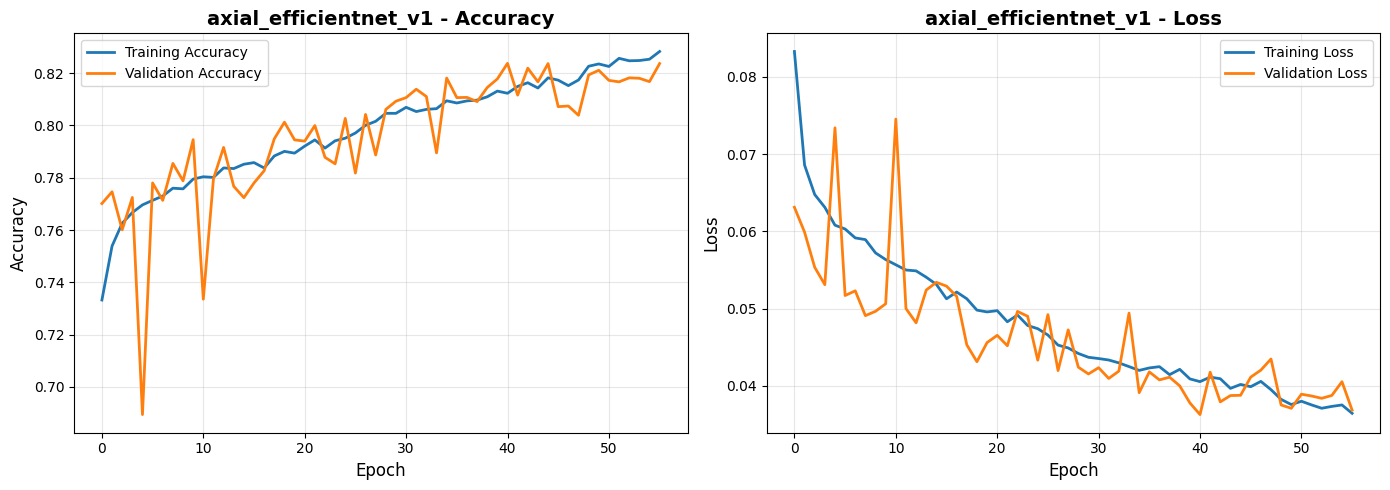


Evaluating model on test set...

Generating predictions...
260/260 ━━━━━━━━━━━━━━━━━━━━ 33s 116ms/step

axial_efficientnet_v1 Evaluation Results
Test Accuracy: 0.8219 (82.19%)

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.55      0.55      0.55       518
ModerateDemented       0.65      0.84      0.74        38
 NonDemented (2)       0.89      0.93      0.91      6356
VeryMildDemented       0.57      0.44      0.50      1380

        accuracy                           0.82      8292
       macro avg       0.66      0.69      0.67      8292
    weighted avg       0.81      0.82      0.81      8292



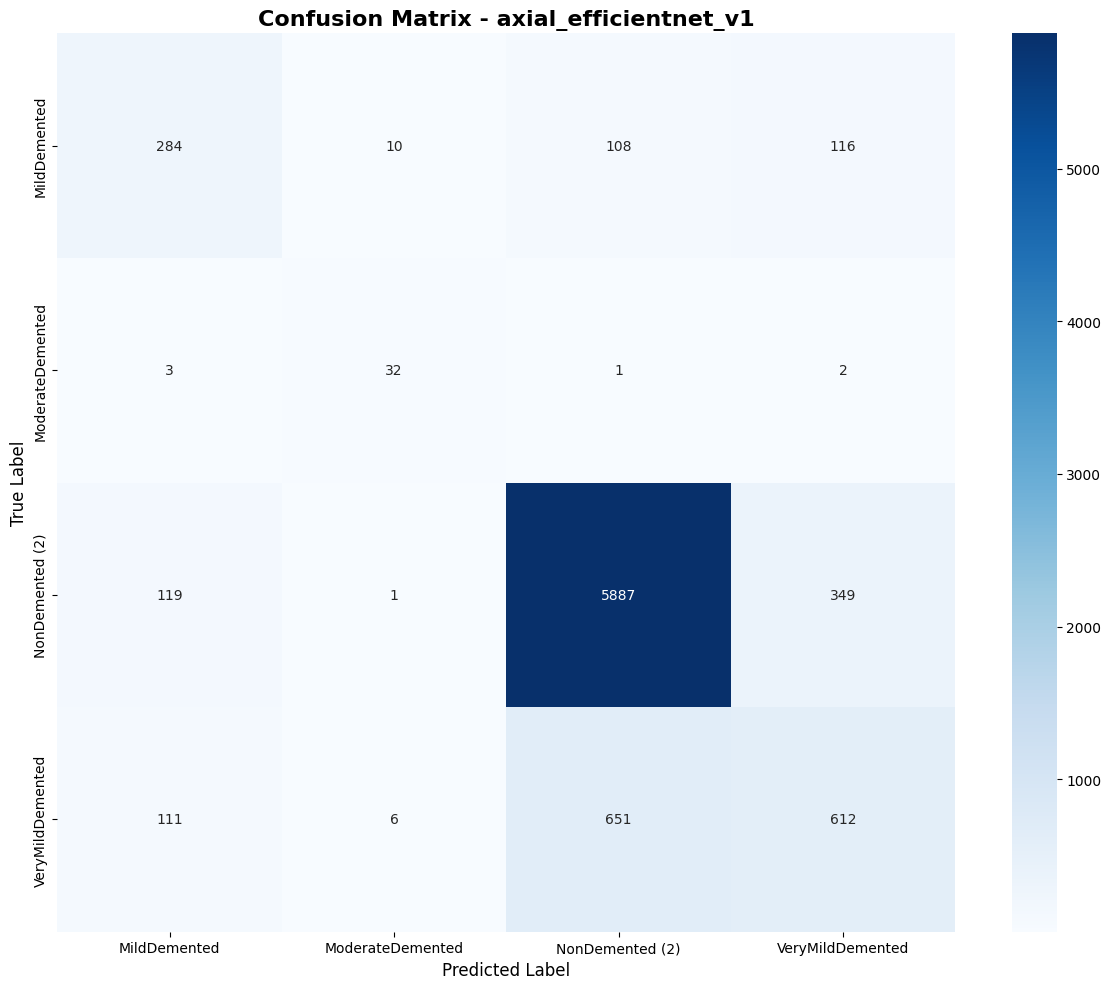


Per-Class Accuracy:
  MildDemented: 0.5483 (54.83%) - 518 samples
  ModerateDemented: 0.8421 (84.21%) - 38 samples
  NonDemented (2): 0.9262 (92.62%) - 6356 samples
  VeryMildDemented: 0.4435 (44.35%) - 1380 samples

Metrics saved to axial_efficientnet_v1_metrics.json

TRAINING COMPLETE
Best Validation Accuracy: 0.8238
Best Validation Loss: 0.0363
Test Accuracy: 0.8219

Model saved as: best_axial_efficientnet_v1.keras
Metrics saved as: axial_efficientnet_v1_metrics.json


In [10]:
# Set GPU memory growth and run training
if __name__ == "__main__":
    # Configure GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Found {len(gpus)} GPU(s)")
        except RuntimeError as e:
            print(f"GPU configuration error: {e}")
    else:
        print("No GPU found, using CPU")

    # Set random seeds for reproducibility
    np.random.seed(Config.SEED)
    tf.random.set_seed(Config.SEED)

    # Run main training pipeline
    results = main()